## Pneumonia Recognition Model

In [1]:
# Import packages

import warnings 
warnings.filterwarnings('ignore')

import os
import sys
import pandas as pd
import pydicom
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from tqdm import tqdm

In [2]:
sys.path.append('../')

from src.mrcnn.config import Config
from src.mrcnn import utils
import src.mrcnn.model as modellib
from src.mrcnn import visualize

Using TensorFlow backend.


In [3]:
path = os.getcwd()
parent = os.path.join(path, os.pardir)

os.chdir(parent)
os.getcwd()

'c:\\ALPOPOV\\STUDY\\PneumoniaRecognition'

In [4]:
# Define constants

DATA_DIR = 'data'
ROOT_DIR = 'models'

TRAIN_DICOM_DIR = os.path.join(DATA_DIR, 'stage_2_train_images')
TEST_DICOM_DIR = os.path.join(DATA_DIR, 'stage_2_test_images')

COCO_WEIGHTS_PATH = 'src\mrcnn\mask_rcnn_coco.h5'

ORIG_SIZE = 1024

In [5]:
def get_images(dicom_dir: str) -> list:
    """Forms a dataset from a set of images
    
    Args: 
        dicom_dir (str): directory with dicom scans

    Returns:
        list: a set of scans

    """
    images = []
    for file_name in os.listdir(dicom_dir):
        images.append(f'{dicom_dir}\{file_name}')
    return list(set(images))


def parse_dataset(dicom_dir: str, annotations: pd.core.frame.DataFrame) -> tuple:
    """Parses the dataset by establishing a link between annotations and scans
    
    Args: 
        dicom_dir (str): directory with dicom scans
        annotations

    Returns:
        list: a set of scans

    """
    images = get_images(dicom_dir)
    image_annotations = {image: [] for image in images}
    for _, row in annotations.iterrows(): 
        image = os.path.join(dicom_dir, row['patientId'] + '.dcm')
        image_annotations[image].append(row)
    return (images, image_annotations)

In [6]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    
    """

    # Give the configuration a recognizable name
    NAME = 'pneumonia'

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU)
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    BACKBONE = 'resnet50'

    NUM_CLASSES = 2 # background + 1 pneumonia classes

    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78 # match target distribution
    DETECTION_NMS_THRESHOLD = 0.01
    
    STEPS_PER_EPOCH = 200


config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [7]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset
    
    """

    def __init__(self, images, images_annotations, height, width) -> None:
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'lung opacity')
        
        # Add images
        for image_id, image_path in enumerate(images):
            annotations = image_annotations[image_path]
            self.add_image('pneumonia', image_id=image_id, path=image_path, annotations=annotations, orig_height=height, orig_width=width)
            
    def get_image_reference(self, image_id: int) -> str:
        """Gets image information
    
        Args: 
            image_id (int): image identificator

        Returns:
            str: image information

        """

        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id: int) -> np.ndarray:
        """Loads image pixel array
    
        Args: 
            image_id (int): image identificator

        Returns:
            np.ndarray: image pixel array

        """

        image_path = self.get_image_reference(image_id)
        dicom_file = pydicom.read_file(image_path)
        image = dicom_file.pixel_array

        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
            
        return image

    def load_mask(self, image_id: int) -> tuple:
        """Loads image mask array
    
        Args: 
            image_id (int): image identificator

        Returns:
            tuple: image mask array, mask class identificator

        """

        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)

        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)

            for image, annotation in enumerate(annotations):
                if annotation['Target'] == 1:
                    x = int(annotation['x'])
                    y = int(annotation['y'])
                    w = int(annotation['width'])
                    h = int(annotation['height'])
                    
                    mask_instance = mask[:, :, image].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, image] = mask_instance
                    class_ids[image] = 1

        return (mask.astype(np.bool), class_ids.astype(np.int32))

In [8]:
annotations = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
annotations.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [9]:
(images, image_annotations) = parse_dataset(TRAIN_DICOM_DIR, annotations)

In [10]:
dicom_file = pydicom.read_file(images[0])
image = dicom_file.pixel_array

In [11]:
dicom_file

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.9827.1517874345.222081
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.9827.1517874345.222081
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

In [12]:
images_list = list(images)
random.seed(42)
random.shuffle(images_list)
val_size = 1500
images_val = images_list[:val_size]
images_train = images_list[val_size:]

print(len(images_train), len(images_val))

25184 1500


In [13]:
data_set_train = DetectorDataset(images_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
data_set_train.prepare()

In [14]:
test_disom_file = random.choice(images_train)
image_annotations[test_disom_file]

[patientId    de449954-b205-4dbb-9c28-fc7fb3bd1016
 x                                             NaN
 y                                             NaN
 width                                         NaN
 height                                        NaN
 Target                                          0
 Name: 24750, dtype: object]

In [15]:
data_set_val = DetectorDataset(images_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
data_set_val.prepare()

(1024, 1024, 3)

[1]


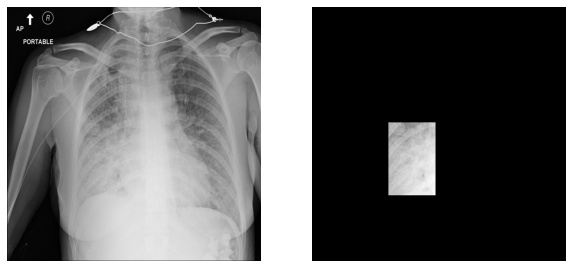

In [16]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0: # look for a mask
    image_id = random.choice(data_set_train.image_ids)
    image_dicom_file = data_set_train.image_reference(image_id)
    image = data_set_train.load_image(image_id)
    (mask, class_ids) = data_set_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_dicom_file)
print(class_ids)

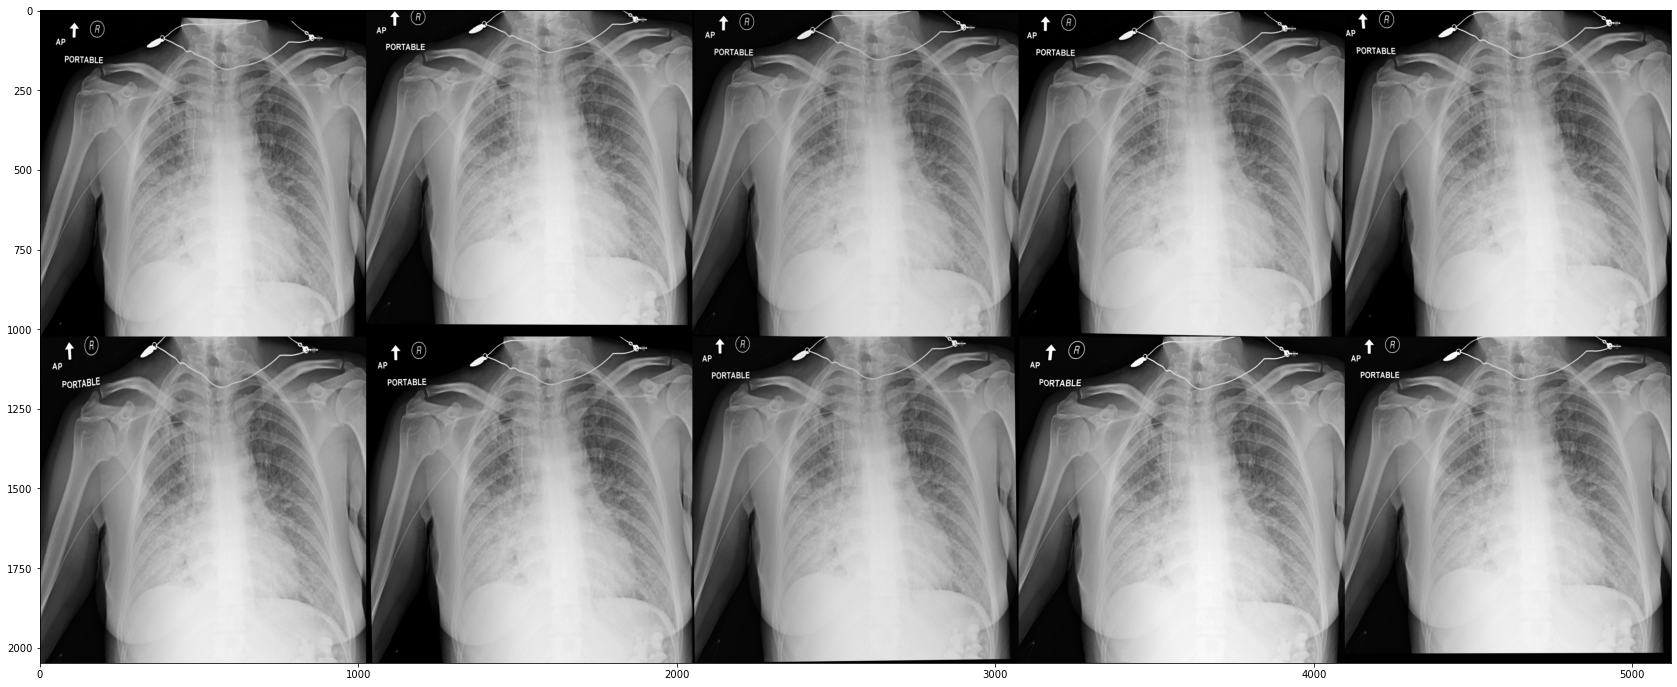

In [17]:
augmentation = iaa.Sequential([
    iaa.OneOf([ 
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))

plt.imshow(imggrid[:, :, 0], cmap='gray')

In [18]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

model.load_weights(COCO_WEIGHTS_PATH,
                   by_name=True,
                   exclude=['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








In [19]:
LEARNING_RATE = 0.012

import warnings 
warnings.filterwarnings("ignore")

In [20]:
%%time

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

model.train(data_set_train, 
            data_set_val,
            learning_rate=LEARNING_RATE/5, # LEARNING_RATE*2 | LEARNING_RATE | LEARNING_RATE/5
            epochs=20, # 2 | 6 | 16
            layers='all', # heads | all | all
            augmentation=None)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.0024000000000000002

Checkpoint Path: models\pneumonia20220511T2347\mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_bra

In [21]:
epochs = range(1, len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,1.602038,0.035798,0.329885,0.350412,0.514083,0.371852,1.980126,0.053092,0.427073,0.373199,0.694782,0.431973
2,1.734283,0.044286,0.399862,0.282222,0.565209,0.442698,1.727310,0.040370,0.386551,0.330792,0.588882,0.380709
3,1.557912,0.031705,0.355821,0.318267,0.494169,0.357942,1.705288,0.040168,0.403810,0.313528,0.556856,0.390919
4,1.541611,0.034296,0.319181,0.307322,0.507230,0.373576,1.682488,0.039262,0.440088,0.282817,0.522616,0.397697
5,1.444819,0.026891,0.300373,0.297573,0.456107,0.363868,1.648287,0.045428,0.380025,0.317751,0.505786,0.399291
6,1.674433,0.045060,0.384406,0.294690,0.534783,0.415488,1.624098,0.045602,0.480342,0.262018,0.447562,0.388568
7,1.668573,0.030171,0.444152,0.318271,0.455452,0.420520,1.593077,0.039816,0.440049,0.243101,0.470504,0.399598
8,1.709483,0.038236,0.398777,0.379762,0.494932,0.397769,1.627304,0.041788,0.455647,0.283797,0.456643,0.389422
9,1.666210,0.039144,0.632457,0.194122,0.382874,0.417605,1.604168,0.034802,0.453072,0.283401,0.447893,0.384993
10,1.496535,0.028883,0.396864,0.233104,0.439700,0.397977,1.542719,0.038858,0.458221,0.229316,0.437209,0.379109


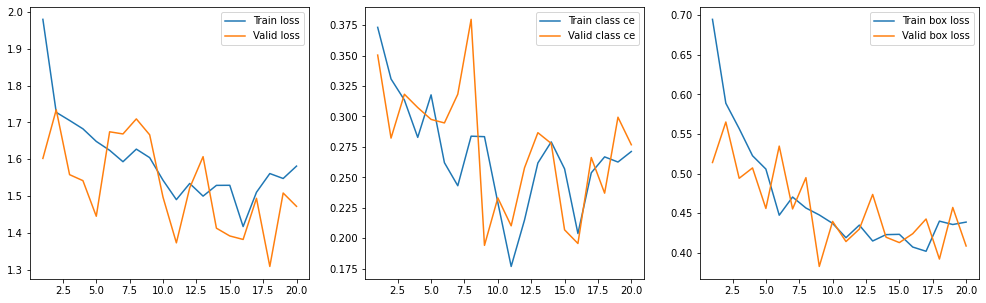

In [22]:
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history['loss'], label='Train loss')
plt.plot(epochs, history['val_loss'], label='Valid loss')
plt.legend()

plt.subplot(132)
plt.plot(epochs, history['mrcnn_class_loss'], label='Train class ce')
plt.plot(epochs, history['val_mrcnn_class_loss'], label='Valid class ce')
plt.legend()

plt.subplot(133)
plt.plot(epochs, history['mrcnn_bbox_loss'], label='Train box loss')
plt.plot(epochs, history['val_mrcnn_bbox_loss'], label='Valid box loss')
plt.legend()

plt.show()

In [23]:
best_epoch = np.argmin(history['val_loss'])
print('Best Epoch:', best_epoch + 1, history['val_loss'][best_epoch])

Best Epoch: 18 1.308361498117447


In [26]:
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(errno.ENOENT, 'Could not find model directory under {}'.format(model.model_dir))
    
files = []

for dir in dir_names: 
    dir_name = os.path.join(model.model_dir, dir)
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith('mask_rcnn'), checkpoints)
    checkpoints = sorted(checkpoints)

    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
        files.append(checkpoint)

model_path = sorted(files)[-1]

print('Found model {}'.format(model_path))

Found model models\pneumonia20220511T2347\mask_rcnn_pneumonia_0018.h5


In [27]:
class InferenceConfig(DetectorConfig):
    """ Overrides detector config

    """

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', config=inference_config, model_dir=ROOT_DIR)

assert model_path != '', 'Provide path to trained weights'
print('Loading weights from ', model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  models\pneumonia20220511T2347\mask_rcnn_pneumonia_0018.h5
Re-starting from epoch 18


In [28]:
def get_colors_for_class_ids(class_ids: np.ndarray) -> list:
    """ Define color of bounded boxex 

    Args: 
        class_ids (np.int32): array of classes

    Returns:
        list: class colors

    """

    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((0.941, 0.204, 0.204))
    return colors

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)
(256, 256, 3)

*** No instances to display *** 



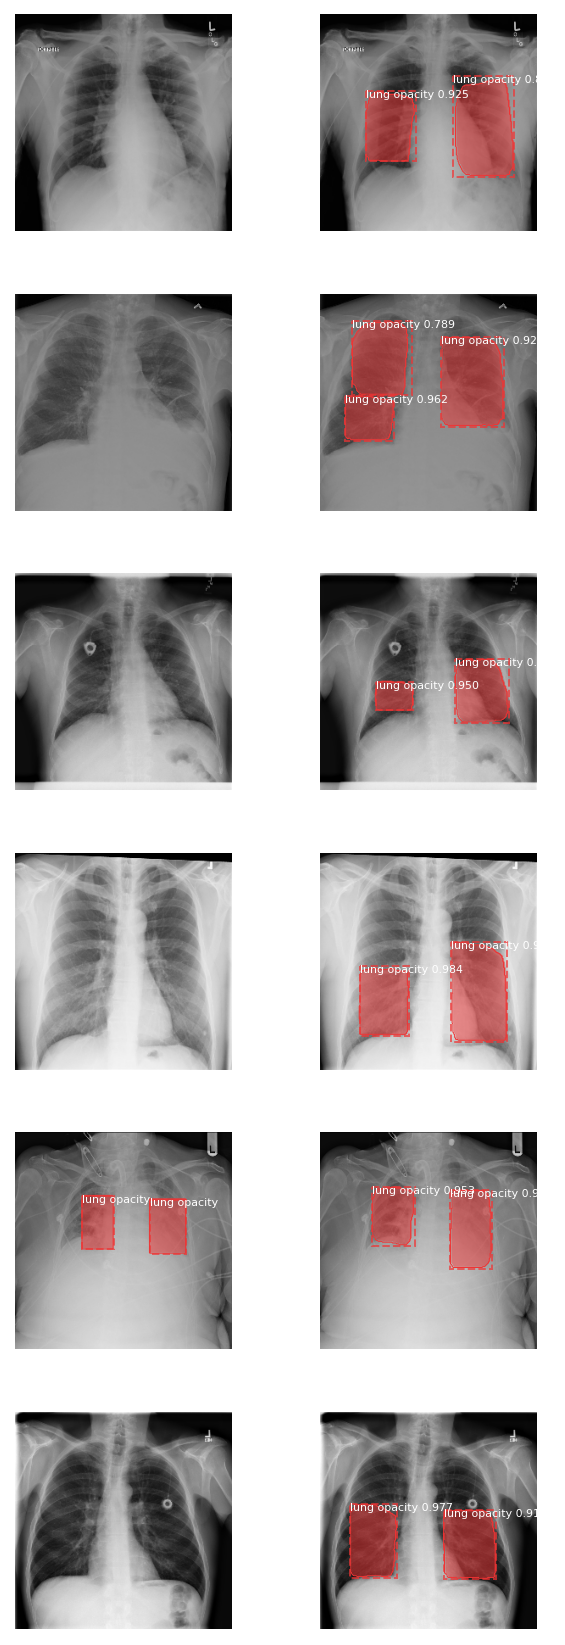

In [29]:
dataset = data_set_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):
    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(data_set_val, inference_config, image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox,
                                gt_mask, gt_class_id,
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id),
                                ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image])
    r = results[0]
    visualize.display_instances(original_image,
                                r['rois'],
                                r['masks'],
                                r['class_ids'], 
                                dataset.class_names,
                                r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']),
                                ax=fig.axes[-1])

In [30]:
test_images = get_images(TEST_DICOM_DIR)

In [31]:
def predict(images: list, filepath='submission.csv', min_conf=0.95) -> None:
    """ Predits pneumonia on scans 

    Args: 
        images (list): test images list

    Returns: None

    """

    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]

    with open(filepath, 'w') as file:
        file.write('patientId, PredictionString\n')

        for image_id in tqdm(images):
            dicom_file = pydicom.read_file(image_id)
            image = dicom_file.pixel_array

            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)

            image, window, scale, padding, crop = utils.resize_image(image,
                                                                     min_dim=config.IMAGE_MIN_DIM,
                                                                     min_scale=config.IMAGE_MIN_SCALE,
                                                                     max_dim=config.IMAGE_MAX_DIM,
                                                                     mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ''
            out_str += patient_id
            out_str += ','

            assert(len(r['rois']) == len(r['class_ids']) == len(r['scores']))
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+'\n')

In [32]:
submission = os.path.join(ROOT_DIR, 'submission.csv')
predict(test_images, filepath=submission)
print(submission)

100%|██████████| 3000/3000 [42:33<00:00,  1.17it/s]

models\submission.csv


In [33]:
output = pd.read_csv(submission)
output.head(20)

,patientId,PredictionString
0,c0359e31-2399-435b-9745-af2da190886f,0.99 256.0 484.0 180.0 116.0
1,2b635aad-66e7-49da-808e-14f59dc98fe0,0.99 548.0 276.0 300.0 464.0 0.95 108.0 632.0...
2,30f45cbe-06c1-4d04-aabf-89c46b85b12b,0.98 504.0 264.0 264.0 420.0 0.96 96.0 308.0 ...
3,021ca4f1-52fd-4881-85cf-c57dfa74566b,0.98 88.0 220.0 332.0 556.0 0.98 532.0 328.0 ...
4,264607e7-a410-4519-b0df-6e5db64c373e,0.97 556.0 240.0 216.0 556.0
5,1e9efec0-222c-464d-9955-55e0aa7bd8be,0.97 600.0 352.0 292.0 624.0 0.96 136.0 164.0...
6,c12861f2-2d63-43f1-b615-cc6e82116faf,NaN
7,31158084-0b59-4f9d-8309-d7254c6ec915,0.98 208.0 500.0 200.0 280.0
8,13da3cfc-5052-486f-81e8-0aec722a0759,0.98 176.0 444.0 212.0 196.0
9,2e523af9-ce17-4d76-bf38-8e9c075e0474,0.95 588.0 388.0 208.0 268.0


2bf6d427-bdad-4122-9f66-7a1d119cf81b
[114  43 186 100]
x 172 y 456 h 228 w 288
[ 98 149 187 216]
x 596 y 392 h 268 w 356


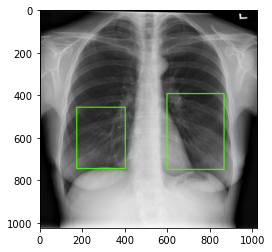

In [34]:
def visualize() -> None:
    """ Visualizes predicts

    Args: None

    Returns: None

    """

    image_id = random.choice(test_images)
    dicom_image = pydicom.read_file(image_id)

    image = dicom_image.pixel_array

    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]

    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 

    resized_image, window, scale, padding, crop = utils.resize_image(image,
                                                                     min_dim=config.IMAGE_MIN_DIM,
                                                                     min_scale=config.IMAGE_MIN_SCALE,
                                                                     max_dim=config.IMAGE_MAX_DIM,
                                                                     mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]

    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print('x {} y {} h {} w {}'.format(x1, y1, width, height))

    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)

visualize()